## Our Queries

**Jupyter Notebook Setup** (i.e. importing packages, libraries, and connection to the Neo4j AuraDB cluster)

In [120]:
import logging
import pandas as pd

from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from neo4j.exceptions import ServiceUnavailable
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal

**Neo4j Instance Connection** 

In [121]:
URI = "neo4j+s://3db72b26.databases.neo4j.io"
user = "neo4j"
password = "WYRcXD9Z4j4ogbClolkT9hRSFvk_WW9G4RkibIgqBwc"
AUTH = (user, password)

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

### Query 1: How Does Voter Participation Vary Among Type Of Democracy and and Across Time

Average Turnout by Type of Democracy Across Time

/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_14047/3508080683.py:13: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\n    MATCH (e:`Election Participation`) \n    WITH e.dem_type AS election_type, \n        avg(e.Voter_Turnout) AS average_turnout,\n        date(e.Date).year AS election_year\n    WHERE election_year <> 2025  // excludes \n    RETURN election_year, election_type, average_turnout\n    ORDER BY election_year, election_type;\n'


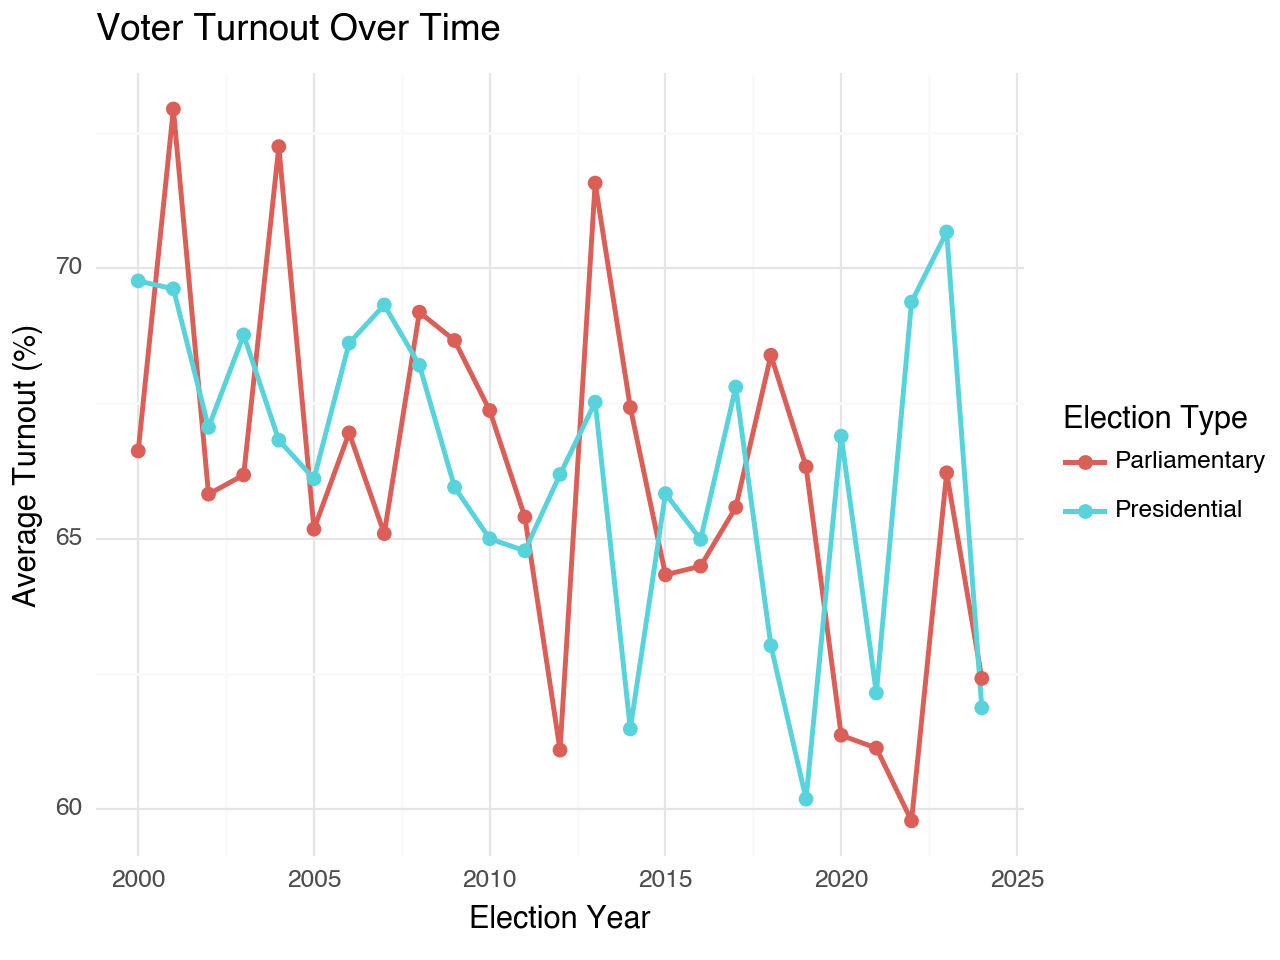

In [114]:
# matching election participation to type of election (presidential, parliamentary), extractng the year from the date and extracting future elections 
query = '''
    MATCH (e:`Election Participation`) 
    WITH e.dem_type AS election_type, 
        avg(e.Voter_Turnout) AS average_turnout,
        date(e.Date).year AS election_year
    WHERE election_year <> 2025  // excludes 
    RETURN election_year, election_type, average_turnout
    ORDER BY election_year, election_type;
'''

def execute_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.data()
    
# USING CHATGPT TO DISPLAY VOTER TURNOUT OVER TIME BY TYPE OF DEMOCRACY

# convert the Neo4j query to a DataFrame for graphical analysis
data = execute_query(query)
df = pd.DataFrame(data)

plot = (ggplot(df, aes(x='election_year', y='average_turnout', color='election_type', group='election_type'))
        + geom_line(size=1)
        + geom_point(size=2)
        + labs(title="Voter Turnout Over Time",
               x="Election Year",
               y="Average Turnout (%)",
               color="Election Type")
        + theme_minimal()
)

# plot displaying
print(plot)

### Query 2: Does an Increase in Special Voting Arrangements (SVAs) Mean Higher Participation?

In [115]:
# counting the number of voting method per country, finding all election participation nodes where ISO3 = Country_Code and there is no compulsory voting, finally computing average voter turnout
records, summary, keys = driver.execute_query(
    '''
    MATCH (vm:`Voting Method`)
    WITH vm.ISO3 AS Country_Code, COUNT(vm) AS Number_of_Voting_Methods

    MATCH (ep:`Election Participation`)
    WHERE ep.ISO3 = Country_Code AND ep.Compulsory_Voting = "No" 
    WITH Number_of_Voting_Methods, AVG(ep.Voter_Turnout) AS Average_Voter_Turnout

    RETURN Number_of_Voting_Methods, Average_Voter_Turnout
    ORDER BY Number_of_Voting_Methods DESC;
    ''',
    database_="neo4j"
)

for r in records:
  print(r.data())

/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_14047/1805832376.py:2: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\n    MATCH (vm:`Voting Method`)\n    WITH vm.ISO3 AS Country_Code, COUNT(vm) AS Number_of_Voting_Methods\n\n    MATCH (ep:`Election Participation`)\n    WHERE ep.ISO3 = Country_Code AND ep.Compulsory_Voting = "No" \n    WITH Number_of_Voting_Methods, AVG(ep.Voter_Turnout) AS Average_Voter_Turnout\n\n    RETURN Number_of_Voting_Methods, Average_Voter_Turnout\n    ORDER BY Number_of_Voting_Methods DESC;\n    '


{'Number_of_Voting_Methods': 3, 'Average_Voter_Turnout': 56.346428571428575}
{'Number_of_Voting_Methods': 2, 'Average_Voter_Turnout': 63.284564102564104}
{'Number_of_Voting_Methods': 1, 'Average_Voter_Turnout': 65.68352941176464}


### Query 3: How Well Do Opinion Polls Predict Election Outcome?

/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_14047/3299550091.py:19: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.


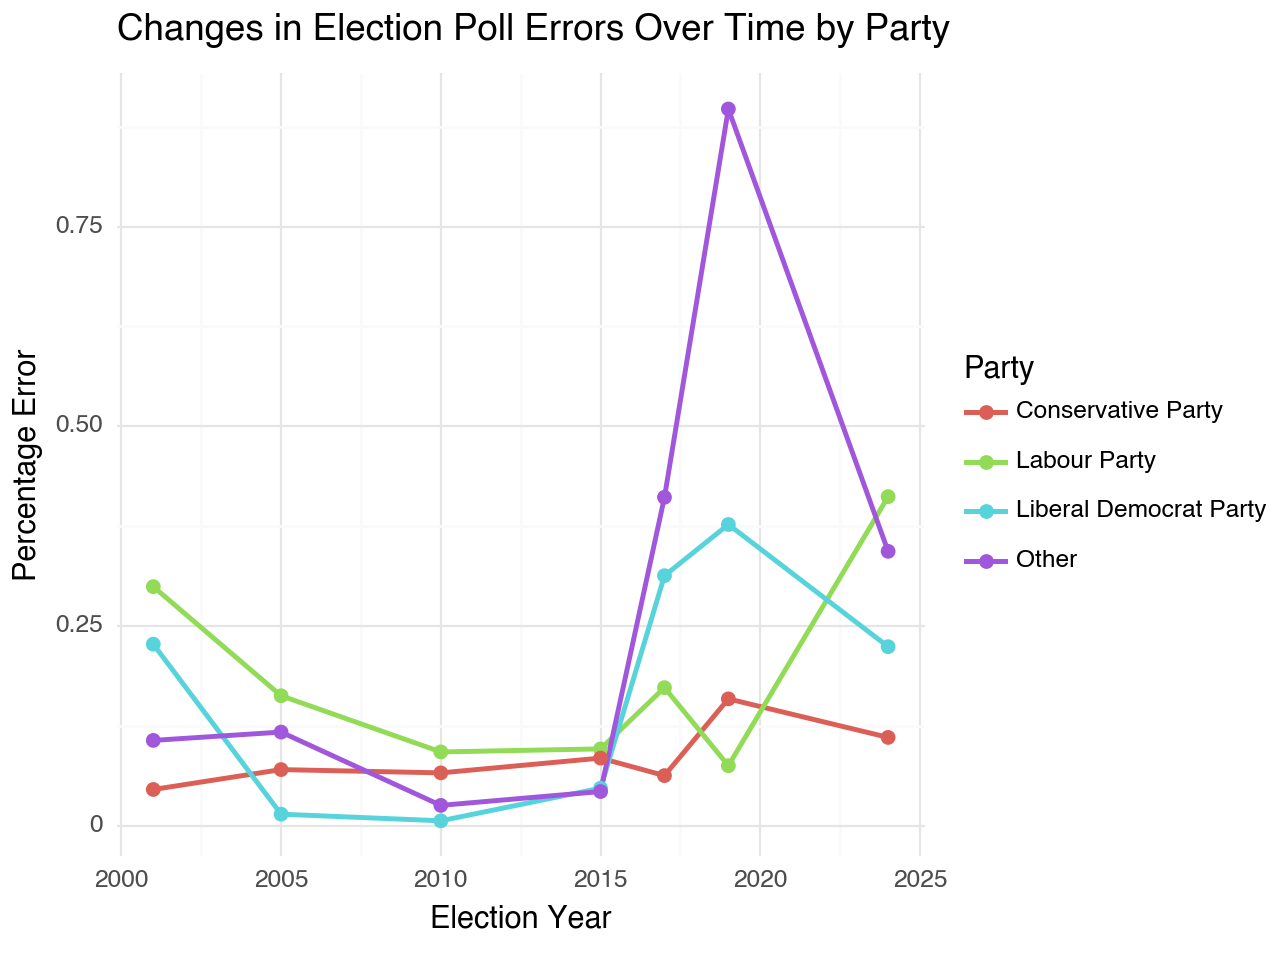

In [103]:
query = '''
    MATCH (uk:`UK Election Results`)-[:PREDICTED_BY]->(ukp:`UK Opinion Polls`)
    WHERE uk.ElectionID = ukp.ElectionID AND uk.Election_Year <> 2025 // excludes 2025 as our data is truncated to the last year (2024)
    RETURN DISTINCT
        uk.Election_Year,
        uk.Winning_Party AS `Winning Party`,
        uk.Elected_Leader AS `Elected Leader`,

        // percentage error for predicted vs. actual vote share % for the Labour, Conservative, Liberal Democratic, and Other parties
        ABS((ukp.Labour_Party - (uk.Labour_Party_Votes * 100.0) / (uk.Labour_Party_Votes + uk.Conservative_Party_Votes + uk.Liberal_Democratic_Party_Votes + uk.Other)) / ((uk.Conservative_Party_Votes * 100.0) / (uk.Labour_Party_Votes + uk.Conservative_Party_Votes + uk.Liberal_Democratic_Party_Votes + uk.Other))) AS Labour_Error,
        ABS((ukp.Conservative_Party - (uk.Conservative_Party_Votes * 100.0) / (uk.Labour_Party_Votes + uk.Conservative_Party_Votes + uk.Liberal_Democratic_Party_Votes + uk.Other)) / ((uk.Conservative_Party_Votes * 100.0) / (uk.Labour_Party_Votes + uk.Conservative_Party_Votes + uk.Liberal_Democratic_Party_Votes + uk.Other))) AS Conservative_Error,
        ABS((ukp.`Liberal Democratic_Party` - (uk.Liberal_Democratic_Party_Votes * 100.0) / (uk.Labour_Party_Votes + uk.Conservative_Party_Votes + uk.Liberal_Democratic_Party_Votes + uk.Other)) / ((uk.Liberal_Democratic_Party_Votes * 100.0) / (uk.Labour_Party_Votes + uk.Conservative_Party_Votes + uk.Liberal_Democratic_Party_Votes + uk.Other))) AS Liberal_Democratic_Error,
        ABS((ukp.Other - (uk.Other * 100.0) / (uk.Labour_Party_Votes + uk.Conservative_Party_Votes + uk.Liberal_Democratic_Party_Votes + uk.Other)) / ((uk.Liberal_Democratic_Party_Votes * 100.0) / (uk.Labour_Party_Votes + uk.Conservative_Party_Votes + uk.Liberal_Democratic_Party_Votes + uk.Other))) AS Other_Error

    ORDER BY uk.Election_Year;
'''

def execute_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.data()

# USING CHATGPT TO DISPLAY POLL INACCURACY OVERTIME, BY UK PARTY

# convert the Neo4j query to a DataFrame for graphical analysis
data = execute_query(query)
df = pd.DataFrame(data)

# reshaping the data to have one row per party and election year
df_melted = df.melt(id_vars=['uk.Election_Year'], 
                    value_vars=['Labour_Error', 'Conservative_Error', 'Liberal_Democratic_Error', 'Other_Error'],
                    var_name='Party', value_name='Error')

# mapping party names to a readable format
df_melted['Party'] = df_melted['Party'].replace({
    'Labour_Error': 'Labour Party',
    'Conservative_Error': 'Conservative Party',
    'Liberal_Democratic_Error': 'Liberal Democrat Party',
    'Other_Error': 'Other'
})

# creating the plot
plot = (ggplot(df_melted, aes(x='uk.Election_Year', y='Error', color='Party', group='Party'))
        + geom_line(size=1) 
        + geom_point(size=2)
        + labs(title="Changes in Election Poll Errors Over Time by Party",
               x="Election Year",
               y="Percentage Error",
               color="Party")
        + theme_minimal()
)

print(plot)

### Query 4: What is the Frequency of Re-Election?

In [124]:
# identifying when a candidate appears in multiple elections, counting how many times they were elected, and returning a list sorted by frequency. 
records, summary, keys = driver.execute_query(
    '''
// Get top 5 parliamentary elections with the highest re-election counts
MATCH (p:`Election Participation`)-[:VOTES_FOR]->(e:`Overall Election Results`)
WHERE e.ElectionID ENDS WITH "PA"
WITH p.Country AS Country_Name,  
     e.Party AS Party_or_Candidate,
     "Parliamentary" AS Election_Type,
     count(*) AS ReElection_Count
RETURN Country_Name, Party_or_Candidate, Election_Type, ReElection_Count
ORDER BY ReElection_Count DESC
LIMIT 5

UNION ALL

// Get top 5 presidential elections with the highest re-election counts
MATCH (p:`Election Participation`)-[:VOTES_FOR]->(e:`Overall Election Results`)
WHERE e.ElectionID ENDS WITH "PR"
WITH p.Country AS Country_Name,  
     e.Candidate AS Party_or_Candidate,
     "Presidential" AS Election_Type,
     count(*) AS ReElection_Count
RETURN Country_Name, Party_or_Candidate, Election_Type, ReElection_Count
ORDER BY ReElection_Count DESC
LIMIT 5;
    ''',
    database_="neo4j"
)

for r in records:
  print(r.data())

/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_14047/3881449041.py:2: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.


{'Country_Name': 'Israel', 'Party_or_Candidate': 'Likud', 'Election_Type': 'Parliamentary', 'ReElection_Count': 8}
{'Country_Name': 'Palau', 'Party_or_Candidate': 'Independent', 'Election_Type': 'Parliamentary', 'ReElection_Count': 7}
{'Country_Name': 'Switzerland', 'Party_or_Candidate': 'Swiss People’s', 'Election_Type': 'Parliamentary', 'ReElection_Count': 6}
{'Country_Name': 'Luxembourg', 'Party_or_Candidate': 'CSV', 'Election_Type': 'Parliamentary', 'ReElection_Count': 5}
{'Country_Name': 'Greece', 'Party_or_Candidate': 'New Democracy', 'Election_Type': 'Parliamentary', 'ReElection_Count': 5}
{'Country_Name': 'Belarus', 'Party_or_Candidate': 'Alexander Lukashenko', 'Election_Type': 'Presidential', 'ReElection_Count': 5}
{'Country_Name': 'Azerbaijan', 'Party_or_Candidate': 'Ilham Aliyev', 'Election_Type': 'Presidential', 'ReElection_Count': 5}
{'Country_Name': 'Bulgaria', 'Party_or_Candidate': 'Georgi Parvanov ', 'Election_Type': 'Presidential', 'ReElection_Count': 4}
{'Country_Name

### Query 5: How Have Democracy Levels Evolved Over Time and Across Political Regimes?


In [118]:
# finding all polity nodes, collecting only year-based properties, sorting in ascending order, and calculating percent change.
records, summary, keys = driver.execute_query(
    '''
    MATCH (p:`Polity Score`)
    WITH p.Economy_ISO3 AS Country_Code, 
        [year IN keys(p) WHERE year =~ '\\d{4}'] AS Years, 
        p
    WITH Country_Code, 
        apoc.coll.sort(Years) AS Sorted_Years, 
        p
    WITH Country_Code, 
        head(Sorted_Years) AS Earliest_Year,
        REDUCE(latest = null, year IN Sorted_Years | 
            CASE 
                WHEN p[toString(year)] IS NOT NULL THEN year 
                ELSE latest 
                END
        ) AS Latest_Year, 
        p
    WITH Country_Code, 
        p[toString(Earliest_Year)] AS Earliest_Score, 
        p[toString(Latest_Year)] AS Latest_Score,
        CASE 
            WHEN p[toString(Earliest_Year)] IS NOT NULL AND 
                p[toString(Earliest_Year)] <> 0 THEN 
                ((p[toString(Latest_Year)] - p[toString(Earliest_Year)]) / 
                p[toString(Earliest_Year)]) * 100 
            ELSE null 
        END AS Percentage_Change
    WHERE Percentage_Change IS NOT NULL // Filter out null values
    WITH Country_Code, 
        Percentage_Change, 
        Earliest_Score,

        // classifying regimes based on a score where < 0 → Authoritarian, = 0 → Hybrid, > 0 → Democratic
        CASE 
            WHEN Earliest_Score < 0 THEN 'Authoritarian'
            WHEN Earliest_Score = 0 THEN 'Hybrid'
            ELSE 'Democratic'
        END AS Regime_Type
    RETURN Country_Code, Percentage_Change, Regime_Type
    ORDER BY Percentage_Change DESC
    LIMIT 5

    UNION ALL

    MATCH (p:`Polity Score`)
    WITH p.Economy_ISO3 AS Country_Code, 
        [year IN keys(p) WHERE year =~ '\\d{4}'] AS Years, 
        p
    WITH Country_Code, 
        apoc.coll.sort(Years) AS Sorted_Years, 
        p
    WITH Country_Code, 
        head(Sorted_Years) AS Earliest_Year,
        REDUCE(latest = null, year IN Sorted_Years | 
            CASE 
                WHEN p[toString(year)] IS NOT NULL THEN year 
                ELSE latest 
                END
        ) AS Latest_Year, 
        p
    WITH Country_Code, 
        p[toString(Earliest_Year)] AS Earliest_Score, 
        p[toString(Latest_Year)] AS Latest_Score,
        CASE 
            WHEN p[toString(Earliest_Year)] IS NOT NULL AND 
                p[toString(Earliest_Year)] <> 0 THEN 
                ((p[toString(Latest_Year)] - p[toString(Earliest_Year)]) / 
                p[toString(Earliest_Year)]) * 100 
            ELSE null 
        END AS Percentage_Change
    WHERE Percentage_Change IS NOT NULL // Filtering out null values
    WITH Country_Code, 
        Percentage_Change, 
        Earliest_Score,
        CASE 
            WHEN Earliest_Score < 0 THEN 'Authoritarian'
            WHEN Earliest_Score = 0 THEN 'Hybrid'
            ELSE 'Democratic'
        END AS Regime_Type
        
    // retrieving top 5 and bottom 5 countries
    RETURN Country_Code, Percentage_Change, Regime_Type
    ORDER BY Percentage_Change ASC
    LIMIT 5;
    ''',
    database_="neo4j"
)

for r in records:
  print(r.data())

/var/folders/sl/p4mhx_n92bd3278hvxdjbw_m0000gn/T/ipykernel_14047/3608375150.py:2: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.


{'Country_Code': 'ZMB', 'Percentage_Change': 500.0, 'Regime_Type': 'Democratic'}
{'Country_Code': 'GHA', 'Percentage_Change': 300.0, 'Regime_Type': 'Democratic'}
{'Country_Code': 'GEO', 'Percentage_Change': 250.0, 'Regime_Type': 'Democratic'}
{'Country_Code': 'COM', 'Percentage_Change': 200.0, 'Regime_Type': 'Authoritarian'}
{'Country_Code': 'DJI', 'Percentage_Change': 200.0, 'Regime_Type': 'Democratic'}
{'Country_Code': 'GIN', 'Percentage_Change': -500.0, 'Regime_Type': 'Authoritarian'}
{'Country_Code': 'TZA', 'Percentage_Change': -400.0, 'Regime_Type': 'Authoritarian'}
{'Country_Code': 'KGZ', 'Percentage_Change': -366.66666666666663, 'Regime_Type': 'Authoritarian'}
{'Country_Code': 'HTI', 'Percentage_Change': -350.0, 'Regime_Type': 'Authoritarian'}
{'Country_Code': 'IRN', 'Percentage_Change': -333.33333333333337, 'Regime_Type': 'Democratic'}
